In [209]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [210]:
data_url = 'https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv'
df = pd.read_csv(data_url)
df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [211]:
# Convert FullDate to datetime format
df['FullDate'] = pd.to_datetime(df['FullDate'])

In [212]:
df.isnull().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

Text(0, 0.5, 'G_A_P')

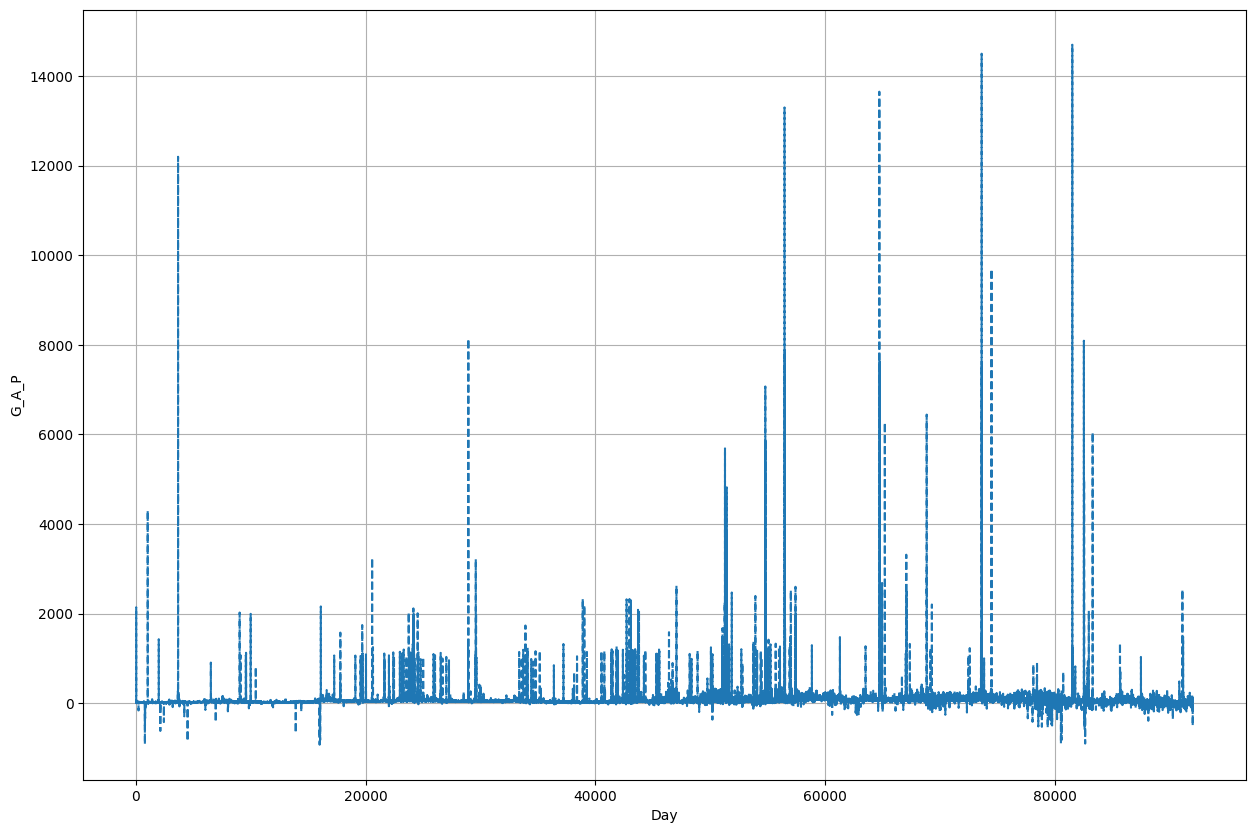

In [213]:

#plot of the daily global_active_power over time
plt.figure(figsize=(15,10))
plt.plot(df.index, df.ElecPrice, '--')
plt.grid()
plt.xlabel('Day')
plt.ylabel('G_A_P')

In [214]:
from statsmodels.tsa.stattools import adfuller
# Set 'FullDate' column as the index
df.set_index('FullDate', inplace=True)
# Resample data on daily frequency and sum 'ElecPrice' for each day
df_daily = df[['SysLoad', 'GasPrice']].resample('D').sum()

# Perform the Augmented Dickey-Fuller test on 'SysLoad' column
result_sysload = adfuller(df_daily['SysLoad'], autolag='AIC')
p_value_sysload = result_sysload[1]

# Perform the Augmented Dickey-Fuller test on 'GasPrice' column
result_gasprice = adfuller(df_daily['GasPrice'], autolag='AIC')
p_value_gasprice = result_gasprice[1]

# Print the p-values to 6 decimal places
print("P-value of SysLoad:", round(p_value_sysload, 6))
print("P-value of GasPrice:", round(p_value_gasprice, 6))

P-value of SysLoad: 0.004254
P-value of GasPrice: 0.045027


In [215]:
# Resample data on daily frequency and sum 'ElecPrice' for each day
df_daily = df[['ElecPrice', 'GasPrice']].resample('D').sum()

# Perform the Augmented Dickey-Fuller test on 'ElecPrice' column
result_elecprice = adfuller(df_daily['ElecPrice'], autolag='AIC')
critical_values_elecprice = result_elecprice[4]

# Perform the Augmented Dickey-Fuller test on 'GasPrice' column
result_gasprice = adfuller(df_daily['GasPrice'], autolag='AIC')
critical_values_gasprice = result_gasprice[4]

# Extract the 10% and 5% critical values from the results
critical_value_10_elecprice = critical_values_elecprice['10%']
critical_value_5_elecprice = critical_values_elecprice['5%']

critical_value_10_gasprice = critical_values_gasprice['10%']
critical_value_5_gasprice = critical_values_gasprice['5%']

# Print the critical values to 4 decimal places
print("10% Critical Value of ElecPrice:", round(critical_value_10_elecprice, 4))
print("5% Critical Value of ElecPrice:", round(critical_value_5_elecprice, 4))

10% Critical Value of ElecPrice: -2.5672
5% Critical Value of ElecPrice: -2.8623


In [216]:
# reset index
power_df_daily = df.reset_index()
power_df_daily.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [217]:
# select columns for predictive model
model_data = power_df_daily[['FullDate', 'ElecPrice']]

#rename columns to 'ds' and 'y' respectively
model_data = model_data.rename(columns={'FullDate':'ds', 'ElecPrice':'y'})

model_data.head()


,ds,y
0,2010-09-01 00:00:00,23.710
1,2010-09-01 01:00:00,22.635
2,2010-09-01 02:00:00,22.565
3,2010-09-01 03:00:00,18.910
4,2010-09-01 04:00:00,18.030


In [218]:

# assign train and test data
train = model_data[:2757]
test = model_data[2757:]
print('train shape', train.shape)
print('test shape', test.shape)

train shape (2757, 2)
test shape (89259, 2)


In [219]:
train2 = train.copy()
test2 = test.copy()

In [220]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpryrm48_q/x036fsi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpryrm48_q/ozjlh6m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68837', 'data', 'file=/tmp/tmpryrm48_q/x036fsi1.json', 'init=/tmp/tmpryrm48_q/ozjlh6m3.json', 'output', 'file=/tmp/tmpryrm48_q/prophet_model4fhbfezu/prophet_model-20230801191129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [221]:

# predict for the next 365 days
#future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-24 21:00:00,13.531416,-109.596548,139.119016,13.531416,13.531416,-0.168931,-0.168931,-0.168931,-2.060519,-2.060519,-2.060519,1.891589,1.891589,1.891589,0.0,0.0,0.0,13.362485
1,2010-12-24 22:00:00,13.520181,-104.157421,134.146285,13.520181,13.520181,-0.540040,-0.540040,-0.540040,-2.479208,-2.479208,-2.479208,1.939169,1.939169,1.939169,0.0,0.0,0.0,12.980141
2,2010-12-24 23:00:00,13.508946,-107.224561,143.433127,13.508946,13.508946,1.201403,1.201403,1.201403,-0.698827,-0.698827,-0.698827,1.900230,1.900230,1.900230,0.0,0.0,0.0,14.710350
3,2010-12-25 00:00:00,13.497712,-117.154283,140.516601,13.497712,13.497712,2.081440,2.081440,2.081440,0.308831,0.308831,0.308831,1.772609,1.772609,1.772609,0.0,0.0,0.0,15.579152
4,2010-12-25 01:00:00,13.486477,-112.317328,137.913275,13.486477,13.486477,-0.019701,-0.019701,-0.019701,-1.575023,-1.575023,-1.575023,1.555322,1.555322,1.555322,0.0,0.0,0.0,13.466776


In [222]:

#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2010-12-24 21:00:00,13.362485,-109.596548,139.119016,13.531416,13.531416,13.531416
1,2010-12-24 22:00:00,12.980141,-104.157421,134.146285,13.520181,13.520181,13.520181
2,2010-12-24 23:00:00,14.710350,-107.224561,143.433127,13.508946,13.508946,13.508946
3,2010-12-25 00:00:00,15.579152,-117.154283,140.516601,13.497712,13.497712,13.497712
4,2010-12-25 01:00:00,13.466776,-112.317328,137.913275,13.486477,13.486477,13.486477
...,...,...,...,...,...,...,...
89254,2021-02-28 19:00:00,-989.464236,-33390.016180,27867.289491,-989.211581,-33419.269175,27961.013903
89255,2021-02-28 20:00:00,-993.207575,-33531.308105,27909.786477,-989.222816,-33419.850105,27961.602199
89256,2021-02-28 21:00:00,-995.826413,-33349.184967,27862.300299,-989.234051,-33420.431035,27962.190495
89257,2021-02-28 22:00:00,-995.192062,-33296.600534,27889.402911,-989.245285,-33421.015409,27962.778791


In [223]:

from sklearn.metrics import mean_squared_error

def mape(test,forecast):
  mape = np.mean(np.abs(np.array(test['y']) - np.array(forecast.yhat))/ np.array(test['y'])) *100
  rmse = np.sqrt(mean_squared_error(np.array(test['y']),np.array(forecast['yhat'])))
  return f'mape value is: {round(mape,2)} and rmse value is: {round(rmse,2)}'

In [224]:
mape(test,forecast)

<ipython-input-223-7928c1937539>:4: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(np.array(test['y']) - np.array(forecast.yhat))/ np.array(test['y'])) *100


'mape value is: inf and rmse value is: 666.96'

KeyError: ignored

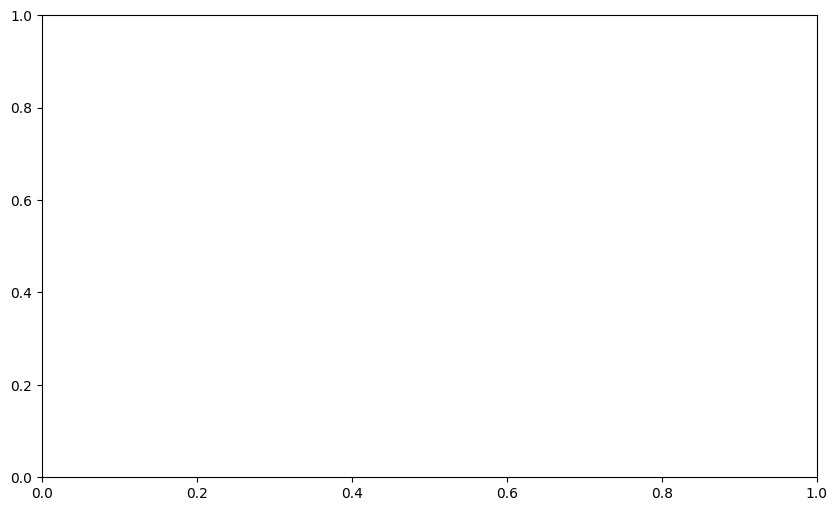

In [225]:
from prophet.plot import plot_yearly
plot_yearly(model)

In [ ]:

power_df_daily.head()

In [ ]:
multi_model = power_df_daily.rename(columns = {'FullDate':'ds','ElecPrice':'y',
                                           'SysLoad':'add1','Tmax':'add2',
                                           'GasPrice':'add3'})
multi_model.head()

In [191]:
#creat multivariate model
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')

In [192]:
# assign train and test data
train2 = multi_model[:2757]
test2 = multi_model[2757:]
print('train shape', train2.shape)
print('test shape', test2.shape)


train shape (2757, 3)
test shape (1077, 3)


In [193]:
model2.fit(train2)
forecast2 = model2.predict(test2)

forecast2

ValueError: ignored

In [111]:
# Question 15: What is the RMSE of the multivariate model?
rmse_multivariate = np.sqrt(mean_squared_error(test['ElecPrice'], forecast_multivariate_test['yhat']))
print("RMSE of the multivariate model:", rmse_multivariate)

RMSE of the multivariate model: 31436.954223217912


In [112]:
# Question 16: Which model performs better? (Lower RMSE is better)
if rmse_univariate < rmse_multivariate:
    print("The univariate model performs better.")
else:
    print("The multivariate model performs better.")

The multivariate model performs better.


In [113]:
# Question 17: What are the coefficients (weights) of the independent variables in the multivariate model?
coefficients = prophet_model_multivariate.params['beta']
print("Coefficients (weights) of the independent variables:")
print(coefficients)

Coefficients (weights) of the independent variables:
[[-4.81029e-04  7.61800e-04 -5.61554e-04  3.17767e-04 -1.13397e-03
   9.46016e-04 -5.41624e-05 -6.81333e-04 -1.18002e-04  6.98884e-04
   9.57440e-04 -3.93425e-04 -4.83685e-04  6.40316e-04  2.78751e-03
  -7.31191e-05  1.24418e-04]]


In [118]:
# Question 18: What is the interpretation of the coefficient of the 'SysLoad' variable?
sysload_coefficient = prophet_model_multivariate.params['beta']['SysLoad']
print("Interpretation of the coefficient of 'SysLoad':", sysload_coefficient)


IndexError: ignored

In [119]:
# Question 19: What is the interpretation of the coefficient of the 'Tmax' variable?
# The interpretation of the coefficient is the change in the dependent variable (ElecPrice) for a one-unit change in the 'Tmax' variable,
# while keeping other variables constant. It shows the impact of 'Tmax' on 'ElecPrice'.

tmax_coefficient = coefficients['add2']
print("Interpretation of the coefficient of 'Tmax':", tmax_coefficient)

IndexError: ignored